### Task 1: Image classification

In [1]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
CURR_DIR = os.path.dirname('__file__')
ROOT_DIR=os.path.join(os.getcwd() ,'..')
sys.path.append(ROOT_DIR)

In [2]:
from omegaconf import OmegaConf
#load configs
config = OmegaConf.load(os.path.join(ROOT_DIR,'run_scripts/configs/config_t2.yaml'))

In [3]:
import wandb
!wandb login

wandb: Currently logged in as: pimakshay (thesis-dm). Use `wandb login --relogin` to force relogin


In [4]:
from utilities.initialize_configs import instantiate_from_configs
classifierModel = instantiate_from_configs(config.model)
gpu_version = '272541_lstm_run0'

In [5]:
%%capture
classifierModel.cuda()

In [6]:
for batch in classifierModel.train_dataloader():
    print(batch[0].size())
    break

torch.Size([16, 3, 150, 150])


In [7]:
classifierModel.model

LSTMModel(
  (lstm): LSTM(67500, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=7, bias=True)
)

In [ ]:
%%capture
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import TQDMProgressBar, Timer, ModelCheckpoint
import time
from pytorch_lightning.loggers import WandbLogger

# stop training after 12 hours
timer = Timer(duration="00:12:00:00")

# or provide a datetime.timedelta
from datetime import timedelta
timer = Timer(duration=timedelta(weeks=1))
timestr = time.strftime("%d%m%y-%H%M%S")
loss_type = classifierModel.loss_type
alpha = classifierModel.learning_rate
task = 'lstm-classification'

wandb_logger = WandbLogger(project="conxai",   
           entity="pimakshay",       # Team
           group=task,       # for organizing runs (e.g. distributed training)
           name=timestr, # name of the run
           notes='running lstm network', # commit message in git
           sync_tensorboard=True)

CKPT_DIR = '/dss/dssfs02/lwp-dss-0001/pn69re/pn69re-dss-0000/ge59suz2/lightning_logs/' + task
CKPT_DIR = CKPT_DIR + '/'+gpu_version+'/checkpoints'
checkpoint = ModelCheckpoint(
    dirpath=CKPT_DIR,
    save_top_k=2,
    monitor="val/loss",    
    filename=timestr + "-{epoch}-{step}-" + "-loss=%s"%loss_type + "-a=%.1E"%alpha
)

trainer = Trainer(max_steps=classifierModel.max_tsteps, accelerator="gpu", devices=-1,logger=wandb_logger, callbacks=[TQDMProgressBar(refresh_rate=10), timer, checkpoint]) # To use all available GPUs put -1 or '-1'
trainer.fit(classifierModel)

# query training/validation/test time (in seconds)
print("Total training time: %.2f mins" % (timer.time_elapsed("train")/60))

# save last checkpoint
timestr = time.strftime("%d%m%y-%H%M%S")
train_loss = "{:.4f}".format(trainer.logged_metrics['train/loss'].item())
CKPT_NAME = timestr + "_lastckpt_tloss_" + str(train_loss) + ".ckpt"
logger_version = "version_"+str(trainer.logger.version)
PATH = "lightning_logs/" + logger_version+ "/checkpoints/"+CKPT_NAME
trainer.save_checkpoint(PATH)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | LSTMModel | 34.8 M
------------------------------------
34.8 M    Trainable params
0         Non-trainable params
34.8 M    Total params
139.038   Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Model Evaluation

In [10]:
import numpy as np
import torch

batch_size=classifierModel.batch_size

test_dataloader = torch.utils.data.DataLoader(
    dataset=classifierModel.test_dataset, batch_size=batch_size, num_workers=4, shuffle=True
)

for step, (x,y) in enumerate(test_dataloader):
    break


In [11]:
import torch.nn.functional as F
outputs = classifierModel.model(x.view(batch_size, -1))

In [12]:
pred = torch.max(F.softmax(outputs),dim=1)
score = pred.values.tolist()
idx = pred.indices.tolist()

/tmp/ipykernel_878154/2653105285.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.max(F.softmax(outputs),dim=1)


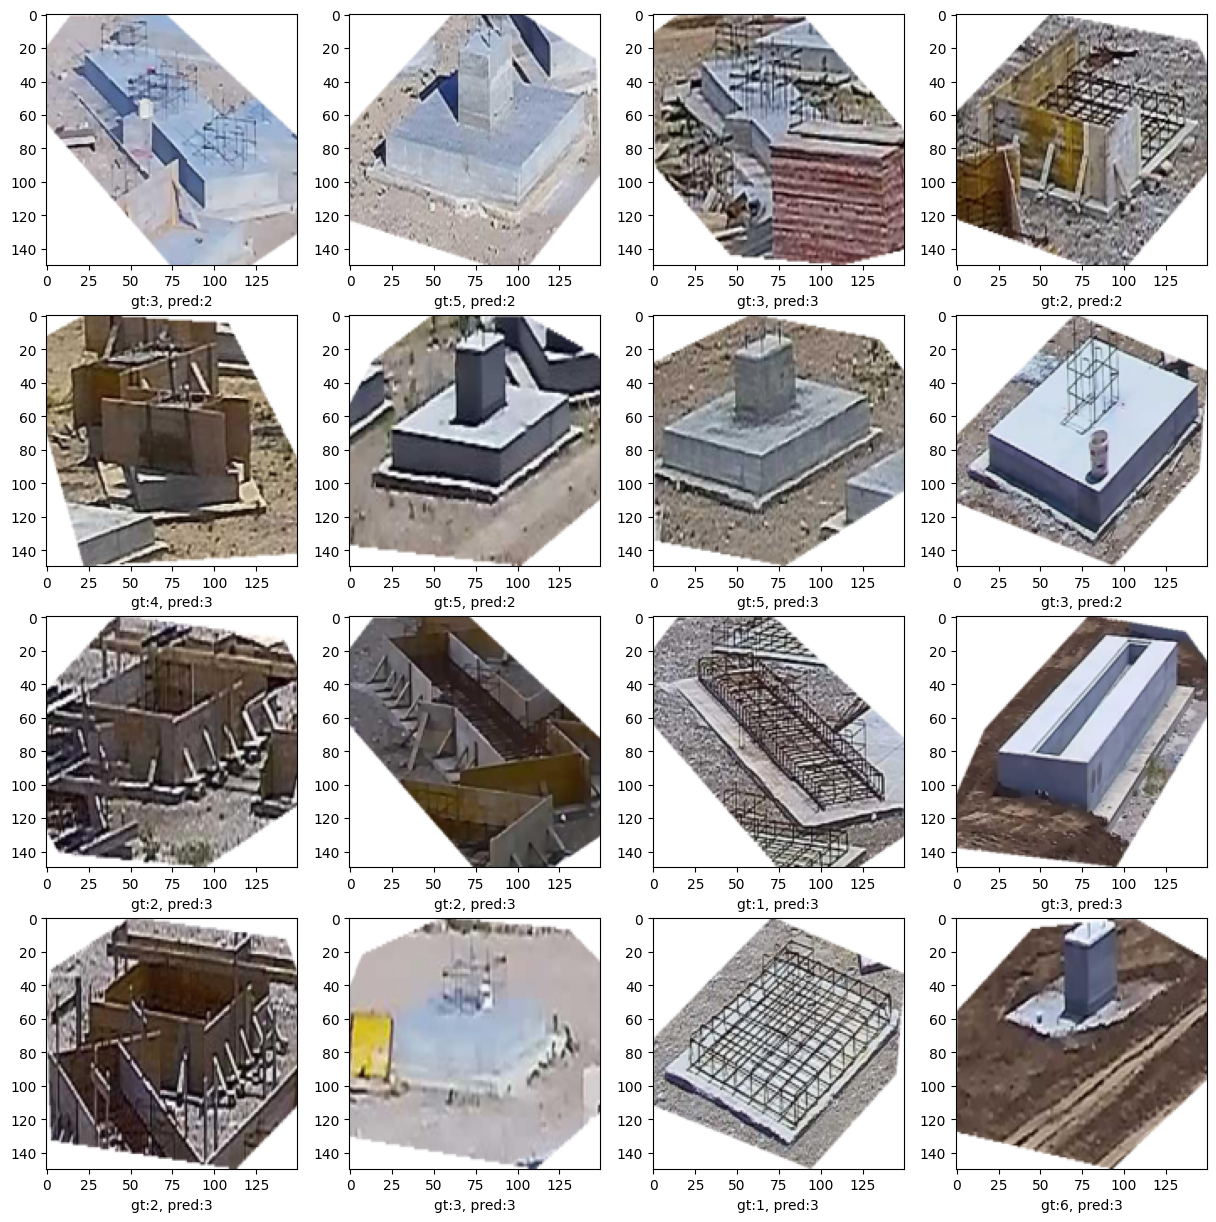

In [16]:
nrows=4
ncols=batch_size//nrows
f, axs = plt.subplots(nrows, ncols, figsize=(15, 15))
for i in range(nrows):
    for j in range(ncols):
        axs[i][j].imshow(x[i*ncols + j].permute(1,2,0))
#         axs[i][j].set_xlabel("gt:"+classifierModel.class_labels_dict[y[i*ncols + j].item()] 
#                              + ", pred:"+classifierModel.class_labels_dict[idx[i*ncols + j]])
        axs[i][j].set_xlabel("gt:"+str(y[i*ncols + j].item()) 
                            + ", pred:"+str(idx[i*ncols + j]))
# plt.show()

import random
rand = random.randint(0, 20)
plt.savefig("results/lstm/plots_bs"+str(batch_size)+"_seed_"+str(rand)+".png")

Accuracy Analysis

In [14]:
def accuracy(preds, labels):
#     _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [15]:
accuracy(pred.indices, y)

tensor(0.2500)